# Import all the necessary dependecies

In [1]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from tqdm.notebook import tqdm

torch.set_num_threads(12)

# Enable CUDA if it's avaiable

In [2]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.set_device(0)
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")


Using GPU: NVIDIA GeForce GTX 1070


# Load the data

In [ ]:
class TimeSeriesDataset(Dataset):
    """
    Helper class for converting long sequences of samples into shorter
    subsequences. The subsequences can overlap by specyfying a non-zero overlap
    value
    """
    def __init__(self, data, subsequnces_count, overlap = 0):
        """
        Constructor for the TimeSeriesDataset class.

        Parameters:
        - data (torch.Tensor): The input sequence
        - subsequnces_count (int): The number of subsequences to be created from the input sequence
        - overlap (int): Number of samples that should be overlapping at the start of the subsequence
        with the previous subsequence
        """
        self.data = data
        self.subsequnces_count = subsequnces_count
        self.overlap = overlap
        self.sequence_length = len(data) // subsequnces_count +  self.overlap

    def __len__(self):
        """
        Return the number of subsequences created from the input sequence

        Parameters:
        - idx (int): the subsequence index
        
        Returns:
        (int): number of subsequences
        """
        return self.subsequnces_count

    def __getitem__(self, idx):
        """
        Return the subsequence at index idx

        Returns:
        (torch.Tensor): Subsequence at idx
        """
        start_idx = idx * (self.sequence_length - self.overlap)
        end_idx = start_idx + self.sequence_length
        sequence = self.data[start_idx:end_idx]
        return sequence

# File names containg train, cross-validation and test data
train_files = ['2021.01.01.csv', '2021.01.02.csv', '2021.01.03.csv',
               '2021.01.04.csv', '2021.01.05.csv', '2021.01.06.csv',
               '2021.01.07.csv', '2021.01.08.csv', '2021.01.09.csv',
               '2021.01.10.csv', '2021.01.11.csv', '2021.01.12.csv',
               '2021.01.13.csv', '2021.01.14.csv', '2021.01.15.csv',
               '2021.01.17.csv', '2021.01.18.csv', '2021.01.19.csv',
               '2021.01.20.csv', '2021.01.22.csv', '2021.01.23.csv',
               '2021.01.24.csv', '2021.01.25.csv', '2021.01.26.csv',
               '2021.01.27.csv', '2021.01.28.csv', '2021.01.29.csv']
cv_files = ['2021.01.30.csv', '2021.01.31.csv', '2021.02.01.csv',
            '2021.02.02.csv', '2021.02.03.csv', '2021.02.04.csv',
            '2021.02.05.csv', '2021.02.06.csv', '2021.02.07.csv']
test_files = ['2021.02.08.csv', '2021.02.09.csv', '2021.02.10.csv',
              '2021.02.11.csv', '2021.02.12.csv', '2021.02.13.csv',
              '2021.02.14.csv', '2021.02.15.csv', '2021.02.16.csv',]

# Load the content of all the files into a pandas DataFrames
train_data = pd.DataFrame()
cv_data = pd.DataFrame()
test_data = pd.DataFrame()
for train_file in train_files:
    df = pd.read_csv(os.path.join('data', 'train', train_file))
    train_data = pd.concat([train_data, df], axis=0)
for cv_file in cv_files:
    df = pd.read_csv(os.path.join('data', 'cv', cv_file))
    cv_data = pd.concat([cv_data, df], axis=0)
for test_file in test_files:
    df = pd.read_csv(os.path.join('data', 'test', test_file))
    test_data = pd.concat([test_data, df], axis=0)


# Remove all samples of class 'outlier' and sort the resulting dataframes by 'time_start'
train_data = train_data[train_data['label'] != 'outlier']
train_data.sort_values(by='time_start', ascending=True, inplace=True)
cv_data = cv_data[cv_data['label'] != 'outlier']
cv_data.sort_values(by='time_start', ascending=True, inplace=True)
test_data = test_data[test_data['label'] != 'outlier']
test_data.sort_values(by='time_start', ascending=True, inplace=True)

# Find all columns that contain non-numeric data and convert them to numbers using an ordinal encoder
object_column_names = train_data.select_dtypes(include='object').columns
ordinal_encoder = OrdinalEncoder()

encoded_object_columns = ordinal_encoder.fit_transform(train_data[object_column_names])
train_data[object_column_names] = encoded_object_columns
encoded_object_columns = ordinal_encoder.transform(cv_data[object_column_names])
cv_data[object_column_names] = encoded_object_columns
encoded_object_columns = ordinal_encoder.transform(test_data[object_column_names])
test_data[object_column_names] = encoded_object_columns


# Seperate feature values from the target values
X_train = train_data.drop(['label'], axis=1)
y_train = train_data['label']
X_cv = cv_data.drop(['label'], axis=1)
y_cv = cv_data['label']
X_test = test_data.drop(['label'], axis=1)
y_test = test_data['label']

simple_imputer = SimpleImputer(strategy='median')
X_train = simple_imputer.fit_transform(X_train)
X_cv = simple_imputer.transform(X_cv)
X_test = simple_imputer.transform(X_test)

# Delete the old DataFrames to free up memory
del train_data, cv_data, test_data

# Normalize the feature values using the standard scaler
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_cv = standard_scaler.transform(X_cv)
X_test = standard_scaler.transform(X_test)

# Convert the numpy arrays (X) and pandas sereies (y) into torch tensors
X_train_tensor = torch.from_numpy(X_train).float()
X_cv_tensor = torch.from_numpy(X_cv).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.tensor(y_train.values).view(-1,1).float()
y_cv_tensor = torch.tensor(y_cv.values).view(-1,1).float()
y_test_tensor = torch.tensor(y_test.values).view(-1,1).float()

# Recombine X and y values into a single tensor, create datasets
# and dataloaders for training, cross-validation and testing
train = torch.cat((X_train_tensor, y_train_tensor), dim=1)
dataset = TimeSeriesDataset(train, 180, 1000)
dataloader_train = DataLoader(dataset, batch_size=1, shuffle=False)

cv = torch.cat((X_cv_tensor, y_cv_tensor), dim=1)
dataset_cv = TimeSeriesDataset(cv, 60, 0)
dataloader_cv = DataLoader(dataset_cv, batch_size=1, shuffle=False)

test = torch.cat((X_test_tensor, y_test_tensor), dim=1)
dataset_test = TimeSeriesDataset(test, 60, 0)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

# Delete the old tensors to free up memory
del X_train_tensor, X_cv_tensor, X_test_tensor, y_train_tensor, y_cv_tensor, y_test_tensor

# Visualize the data

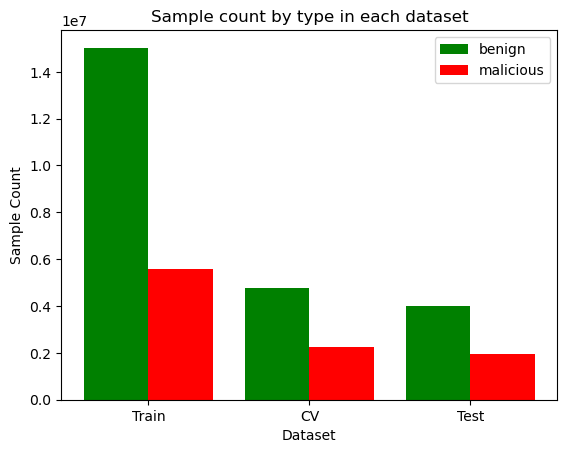

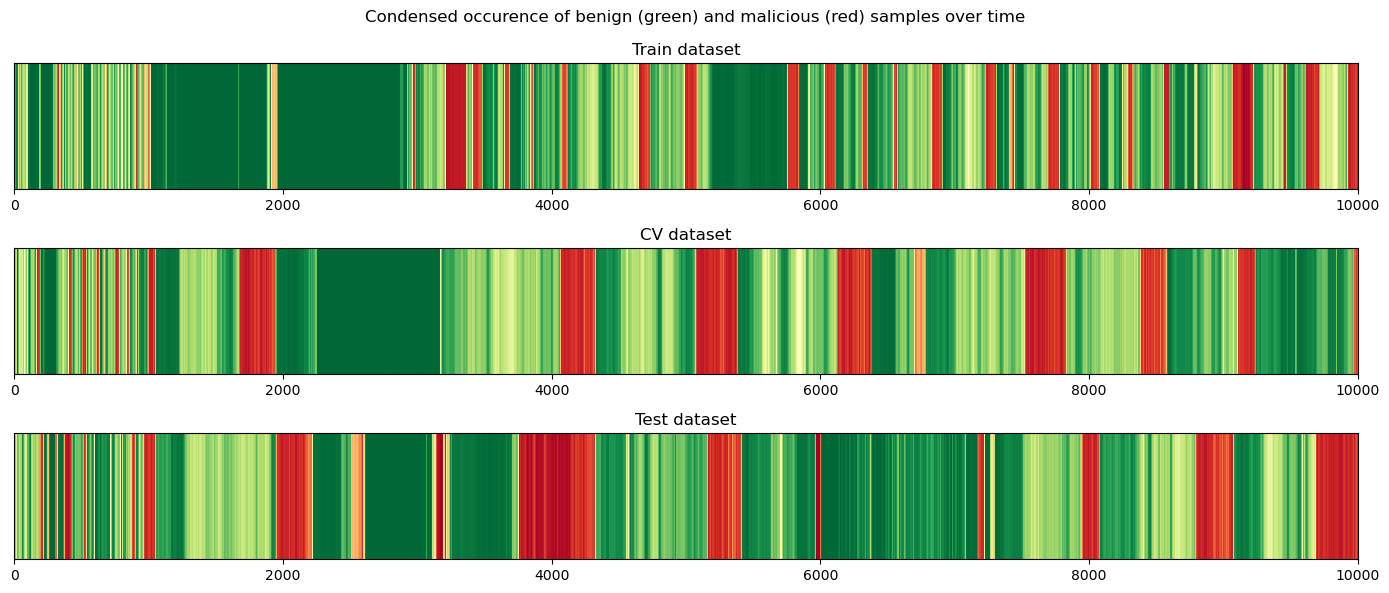

In [4]:
def condense_sequence(sequence, target_length=10000):
    """
    Helper function for condesing a sequence into a shorter sequence
    of length equal to target_length

    Paramters:
    - sequence (torch.Tensor): The input sequence to condense
    - target_length (int): The length of the new condensed sequence

    Returns:
    (np.ndarray): the resulting condensed sequence as a numpy array of floats 
    """
    segment_length = len(sequence) // target_length
    condensed_data = []
    for i in range(target_length):
        segment = sequence[i*segment_length : (i+1)*segment_length]
        proportion_of_ones = np.mean(segment)
        condensed_data.append(proportion_of_ones)
    return np.array(condensed_data)


def plot_condensed_sequence(condensed_seq, ax, title):
    """
    Function for ploting the condensed sequence as a horizontal bar graph

    Parameters:
    - condensed_seq (numpy.ndarray): the condensed sequence composed of floats
    - ax (matplotlib.axes._axes.Axes): a matplotlib subplot used to plot the input sequence
    - title (str): the title of the subplot with the ploted sequence
    """
    ax.imshow(condensed_seq.reshape(1, -1), cmap='RdYlGn_r', aspect='auto', extent=[0, len(condensed_seq), 0, 1])
    ax.get_yaxis().set_visible(False)
    ax.set_xlim(0, len(condensed_seq))
    ax.set_title(title)


# Plot the sample count of each class in each dataset
plt.bar(1, len(y_train[y_train == 0]), color='green', label='benign')
plt.bar(1.8, len(y_train[y_train == 1]), color='red', label='malicious')
plt.bar(3, len(y_cv[y_cv == 0]), color='green')
plt.bar(3.8, len(y_cv[y_cv == 1]), color='red')
plt.bar(5, len(y_test[y_test == 0]), color='green')
plt.bar(5.8, len(y_test[y_test == 1]), color='red')

tick_locations = [1.4, 3.4, 5.4]
tick_labels = ['Train', 'CV', 'Test']
plt.xticks(tick_locations, tick_labels)
plt.title('Sample count by type in each dataset')
plt.ylabel('Sample Count')
plt.xlabel('Dataset') 
plt.legend()
plt.show()

# Plot the occurence of each class over time
y_train_condensed =condense_sequence(y_train, 10000)
y_cv_condensed =condense_sequence(y_cv, 10000)
y_test_condensed =condense_sequence(y_test, 10000)

fig, axs = plt.subplots(3, 1, figsize=(14, 6))
fig.suptitle('Condensed occurence of benign (green) and malicious (red) samples over time')
plot_condensed_sequence(y_train_condensed, axs[0], title='Train dataset')
plot_condensed_sequence(y_cv_condensed, axs[1], title='CV dataset')
plot_condensed_sequence(y_test_condensed, axs[2], title='Test dataset')
plt.tight_layout()
plt.show()


# Define different recurrent ANN models

In [5]:
# A RNN model composed of three RNN layers and a single LSTM layer
# Dropout layers are introduced between recursive layers to prevent overfitting
class RNNHybridAnomalyDetector(nn.Module):
    def __init__(self):
        super(RNNHybridAnomalyDetector, self).__init__()
        self.rnn1 = nn.RNN(15, 60)
        self.dropout1 = nn.Dropout(p=0.2)
        self.rnn2 = nn.RNN(60, 220)
        self.dropout2 = nn.Dropout(p=0.3)
        self.rnn3 = nn.RNN(220, 80)
        self.dropout3 = nn.Dropout(p=0.2)
        self.lstm1 = nn.LSTM(80, 30)
        self.fc1 = nn.Linear(30,1)

    def forward(self, x):
        x, _ = self.rnn1(x)
        x = self.dropout1(x)
        x, _ = self.rnn2(x)
        x = self.dropout2(x)
        x, _ = self.rnn3(x)
        x = self.dropout3(x)
        x, _ = self.lstm1(x)
        x = self.fc1(x)
        return torch.sigmoid(x)


# A recurrent model comprised entirely of GRU layers
class GRUAnomalyDetector(nn.Module):
    def __init__(self):
        super(GRUAnomalyDetector, self).__init__()
        self.gru1 = nn.GRU(15, 60, num_layers=3, dropout=0.3)
        self.dropout1 = nn.Dropout(p=0.2)
        self.gru2 = nn.GRU(60, 40, num_layers=3, dropout=0.3)
        self.dropout2 = nn.Dropout(p=0.2)
        self.gru3 = nn.GRU(40, 20, num_layers=3, dropout=0.3)
        self.fc1 = nn.Linear(20,1)
        
    def forward(self, x):
        x, _ = self.gru1(x)
        x = self.dropout1(x)
        x, _ = self.gru2(x)
        x = self.dropout2(x)
        x, _ = self.gru3(x)
        x = self.fc1(x)
        return torch.sigmoid(x)

# A recurrent model comprised entirely of LSTM layers
class LSTMAnomalyDetector(nn.Module):
    def __init__(self):
        super(LSTMAnomalyDetector, self).__init__()
        self.lstm1 = nn.LSTM(15, 60, num_layers=4, dropout=0.25)
        self.fc1 = nn.Linear(60, 1)
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.fc1(x)
        return torch.sigmoid(x)

# Modified BCE loss function with class weights
def BCELoss_class_weighted(weights):
    def loss(input, target):
        input = torch.clamp(input,min=1e-7,max=1-1e-7)
        bce = - weights[1] * target * torch.log(input) - (1 - target) * weights[0] * torch.log(1 - input)
        return torch.mean(bce)
    return loss

# Train the models

## Define a function for fitting different models

In [6]:
def fit_model(model, model_name, dataloader_train, dataloader_cv, loss_fn, optimizer, epochs=100):
    """
    A helper function for quickly fitting a pytorch model

    Parameters:
    - model: A pytorch ANN model
    - model_name(str): Name of the model used during saving checkpoints
    - dataloader_train (torch.utils.data.dataloader.DataLoader): A pytorch dataloader with train data
    - dataloader_cv (torch.utils.data.dataloader.DataLoader): A pytorch dataloader with cross-validation data
    - loss_fn (function): Loss function used during training and validation
    - optimizer: A pytroch optimizer used during traing
    - epchos (int): Number of epochs for which the model should be trained

    Returns:
    - (dict): A dictionary containing information about the model's performance in each epoch
    """
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy':[], 'epochs': epochs}
    for epoch in range(epochs):
        batch_loss_list = []
        for batch in tqdm(dataloader_train, total=len(dataloader_train), desc="Training", unit="batch", colour='green'):
            optimizer.zero_grad()
            y_pred = model(batch[:,:,:15].to(device))
            loss = loss_fn(y_pred, batch[:,:,15].to(device).unsqueeze(2))
            loss.backward()
            optimizer.step()
            batch_loss_list.append(loss.item())
            
        model.eval()
        batch_accuracy_list = []
        batch_val_accuracy_list = []
        batch_val_loss_list = []
        with torch.no_grad():
            for batch in tqdm(dataloader_train, total=len(dataloader_train), desc="Evaluating", unit="batch", colour='blue'):
                # Make predictions for each batch in the training set
                y_pred = model(batch[:,:,:15].to(device)).cpu()
                # Convert the predictions into 0 and 1 values by applying a threshold
                y_pred  = (y_pred > 0.5).float()
                # Compute the accuracy
                accuracy = (y_pred == batch[:,:,15].unsqueeze(2)).float().mean()
                batch_accuracy_list.append(accuracy)
    
            for batch in tqdm(dataloader_cv, total=len(dataloader_cv), desc="Evaluating", unit="batch", colour='orange'):
                # Make predictions using the cross-validation dataset
                y_pred_val = model(batch[:,:,:15].to(device)).cpu()
                loss_val = loss_fn(y_pred_val, batch[:,:,15].unsqueeze(2))
                batch_val_loss_list.append(loss_val.item())
                y_pred_val = (y_pred_val > 0.5).float()
                accuracy_val = (y_pred_val == batch[:,:,15].unsqueeze(2)).float().mean()
                batch_val_accuracy_list.append(accuracy_val)
    
        epoch_loss = float(np.mean(batch_loss_list))
        epoch_accuracy = float(np.mean(batch_accuracy_list))
        epoch_val_loss = float(np.mean(batch_val_loss_list))
        epoch_val_accuracy = float(np.mean(batch_val_accuracy_list))
        history['loss'].append(epoch_loss)
        history['accuracy'].append(np.mean(epoch_accuracy))
        history['val_loss'].append(np.mean(epoch_val_loss))
        history['val_accuracy'].append(np.mean(epoch_val_accuracy))
        print(f'Epoch: {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}')
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), os.path.join('models', 'checkpoints', f'{model_name}_checkpoint_epoch_{epoch+1}.pt'))
        model.train()
    
    return history

## Define the models' architecture

In [7]:
# Define all the models and display information about their architecture
model1 = RNNHybridAnomalyDetector().to(device)
model2 = GRUAnomalyDetector().to(device)
model3 = LSTMAnomalyDetector().to(device)
print(summary(model1))
print(summary(model2))
print(summary(model3))

Layer (type:depth-idx)                   Param #
RNNHybridAnomalyDetector                 --
├─RNN: 1-1                               4,620
├─Dropout: 1-2                           --
├─RNN: 1-3                               62,040
├─Dropout: 1-4                           --
├─RNN: 1-5                               24,160
├─Dropout: 1-6                           --
├─LSTM: 1-7                              13,440
├─Linear: 1-8                            31
Total params: 104,291
Trainable params: 104,291
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
GRUAnomalyDetector                       --
├─GRU: 1-1                               57,780
├─Dropout: 1-2                           --
├─GRU: 1-3                               31,920
├─Dropout: 1-4                           --
├─GRU: 1-5                               8,760
├─Linear: 1-6                            21
Total params: 98,481
Trainable params: 98,481
Non-trainable params: 0
Layer (type:depth-idx)        

## Fit models

In [ ]:
# Define the loss function and optimizer for each model. Fit every model and save it
# along with its performance over epochs
model1_loss_fn = BCELoss_class_weighted([1.0, 10.0])
model1_optimizer = optim.Adam(model1.parameters(), lr=0.005)
model1_history = fit_model(model1, 'model1', dataloader_train, dataloader_cv, model1_loss_fn, model1_optimizer, epochs=150)
torch.save(model1.state_dict(), os.path.join('models', 'model1.pt'))
with open(os.path.join('models', 'model1_history.json'), "w") as file:
    json.dump(model1_history, file)

model2_loss_fn = BCELoss_class_weighted([1.0, 10.0])
model2_optimizer = optim.Adam(model2.parameters(), lr=0.001)
model2_history = fit_model(model2, 'model2', dataloader_train, dataloader_cv, model2_loss_fn, model2_optimizer, epochs=250)
torch.save(model2.state_dict(), os.path.join('models', 'model2.pt'))
with open(os.path.join('models','model2_history.json'), "w") as file:
    json.dump(model2_history, file)

model3_loss_fn = BCELoss_class_weighted([1.0, 10.0])
model3_optimizer = optim.Adam(model3.parameters(), lr=0.001)
model3_history = fit_model(model3, 'model3', dataloader_train, dataloader_cv, model3_loss_fn, model3_optimizer, epochs=250)
torch.save(model3.state_dict(), os.path.join('models', 'model3.pt'))
with open(os.path.join('models','model3_history.json'), "w") as file:
    json.dump(model3_history, file)

torch.cuda.empty_cache()

# Search of an optimal threshold value for each model

In [9]:
# Load models from files
model1.load_state_dict(torch.load(map_location=torch.device(device), f=os.path.join('models', 'model1.pt')))
# model2 and model3 have reached peak performance at around epoch 240, therefore the original model2.pt and model3.pt files have
# been substituted with model2_checkpoint_epoch_240.pt and model3_checkpoint_epoch_240.pt, renamed to model2.pt and model3.pt 
# accordingly for consistency
model2.load_state_dict(torch.load(map_location=torch.device(device), f=os.path.join('models', 'model2.pt')))
model3.load_state_dict(torch.load(map_location=torch.device(device), f=os.path.join('models', 'model3.pt')))

# Set the models in evaluation mode
model1.eval()
model2.eval()
model3.eval()

models = [model1, model2, model3]

y_true_combined = torch.zeros(1,0,1)
for batch in dataloader_cv:
    y_true_combined = torch.cat((y_true_combined, batch[:,:,15].cpu().unsqueeze(2)), dim=1)
y_true_combined = y_true_combined.numpy().ravel()


def threshold_search(dataloader_cv, y_true_combined, range_start = 0, range_end = 1, search_depth = 5):
    """
    Function that recursively searches for an opmtimal threshold value, which optmizes the f1-score

    Parameters:
    - dataloader_cv (torch.utils.data.dataloader.DataLoader): A pytorch dataloader with cross-validation data
    - y_true_combined (torch.Tensor): Torch tensor containing the ground truth labels for data in dataloader_cv
    - range_start (float): Search range start
    - range_end (float): Search range end
    - search_depth (float): Determines the search depth

    Returns:
    - (float): Best found threshold value
    """
    # Nested function for hidding the steps_count and current_depth arguments
    def _threshold_search(dataloader_cv, y_true_combined, range_start, range_end, search_depth, steps_count = 11, current_depth = 1):
        best_f1 = -1
        best_threshold = -1
        step = search_depth
        for threshold in tqdm(np.linspace(range_start, range_end, steps_count), total=len(np.linspace(range_start, range_end, steps_count)), 
                              desc=f'Finding optimal thresholds - step {current_depth}/{search_depth}', unit="threshold_value", colour='yellow'):
            y_pred_combined = torch.zeros(1,0,1)
            # Make predictions using the test dataset for all batches
            for batch in dataloader_cv:
                y_pred = model(batch[:,:,:15].to(device)).cpu()
                y_pred = (y_pred > threshold).float()
                y_pred_combined = torch.cat((y_pred_combined, y_pred), dim=1)
            y_pred_combined = y_pred_combined.numpy().ravel()
            f1 = f1_score(y_true_combined, y_pred_combined)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
    
        if current_depth == search_depth:
            return best_threshold
        else:
            boundary_range = (range_end - range_start) / (steps_count - 1)
            range_start = max(best_threshold - boundary_range, 0)
            range_end = min(best_threshold + boundary_range, 1)
            current_depth += 1
            step += 1
            return _threshold_search(dataloader_cv, y_true_combined, range_start, range_end, search_depth, 21, current_depth)
    return _threshold_search(dataloader_cv, y_true_combined, range_start, range_end, search_depth)


model_thresholds = {}
for idx, model in enumerate(models):
    progress_val = 0
    best_f1 = -1
    best_threshold = -1
    # Make predictions using the test dataset for all batches
    with torch.no_grad():
        best_threshold = threshold_search(dataloader_cv, y_true_combined, 0, 1, 5)
    print(f'Model {idx + 1} optimal threshold: {best_threshold}')
    model_thresholds['model' + (str(idx + 1))] = best_threshold
    
print(model_thresholds)

Finding optimal thresholds - step 1/5:   0%|          | 0/11 [00:00<?, ?threshold_value/s]

Finding optimal thresholds - step 2/5:   0%|          | 0/21 [00:00<?, ?threshold_value/s]

Finding optimal thresholds - step 3/5:   0%|          | 0/21 [00:00<?, ?threshold_value/s]

Finding optimal thresholds - step 4/5:   0%|          | 0/21 [00:00<?, ?threshold_value/s]

Finding optimal thresholds - step 5/5:   0%|          | 0/21 [00:00<?, ?threshold_value/s]

Model 1 optimal threshold: 0.6532700000000001


Finding optimal thresholds - step 1/5:   0%|          | 0/11 [00:00<?, ?threshold_value/s]

Finding optimal thresholds - step 2/5:   0%|          | 0/21 [00:00<?, ?threshold_value/s]

Finding optimal thresholds - step 3/5:   0%|          | 0/21 [00:00<?, ?threshold_value/s]

Finding optimal thresholds - step 4/5:   0%|          | 0/21 [00:00<?, ?threshold_value/s]

Finding optimal thresholds - step 5/5:   0%|          | 0/21 [00:00<?, ?threshold_value/s]

Model 2 optimal threshold: 0.4559


Finding optimal thresholds - step 1/5:   0%|          | 0/11 [00:00<?, ?threshold_value/s]

Finding optimal thresholds - step 2/5:   0%|          | 0/21 [00:00<?, ?threshold_value/s]

Finding optimal thresholds - step 3/5:   0%|          | 0/21 [00:00<?, ?threshold_value/s]

Finding optimal thresholds - step 4/5:   0%|          | 0/21 [00:00<?, ?threshold_value/s]

Finding optimal thresholds - step 5/5:   0%|          | 0/21 [00:00<?, ?threshold_value/s]

Model 3 optimal threshold: 0.40924000000000005
{'model1': 0.6532700000000001, 'model2': 0.4559, 'model3': 0.40924000000000005}


# Plot the model's performance

Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

Model 1
Accuracy: 0.998597859170343
Precision: 0.9984904806685712
Recall: 0.997148481833477
F1 score: 0.9978190300269031


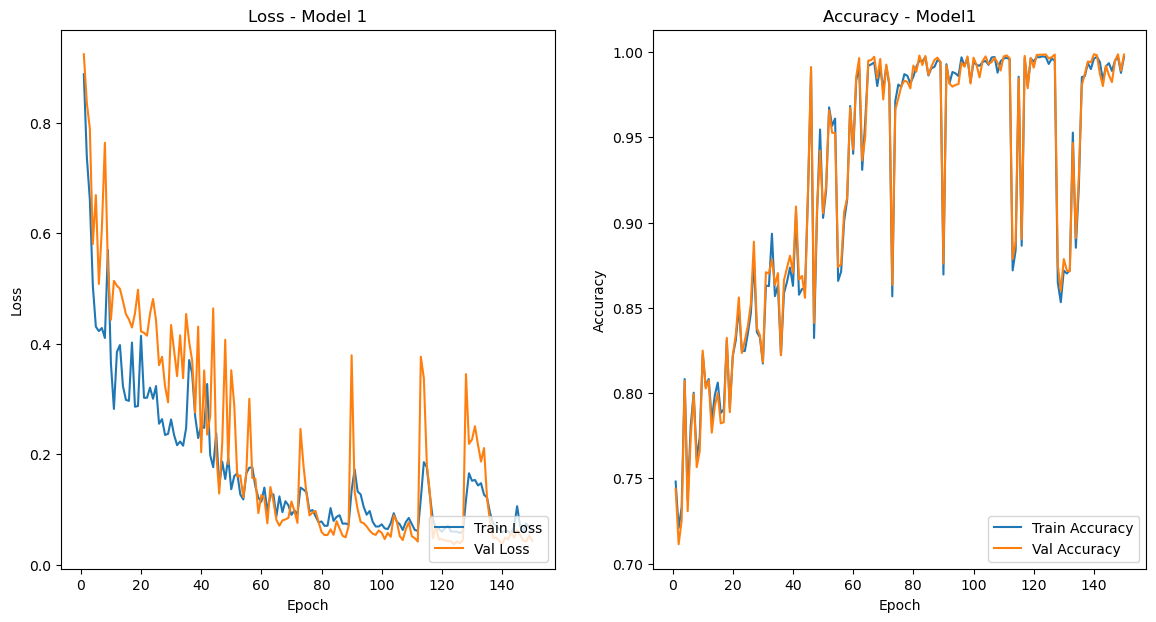

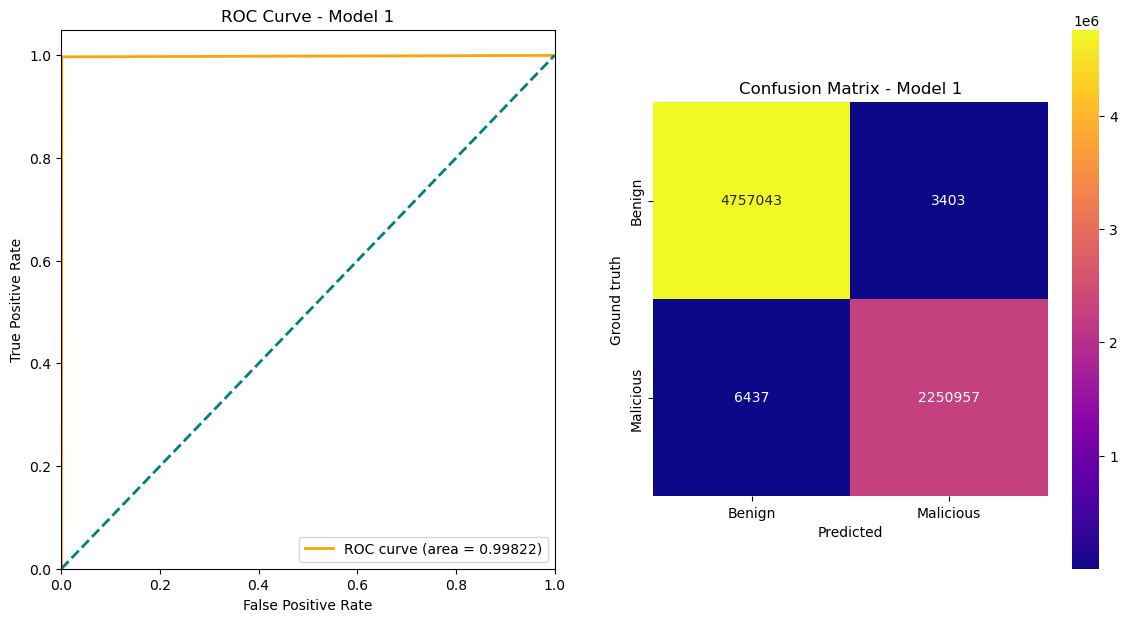

Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

Model 2
Accuracy: 0.998302754123776
Precision: 0.996106238017027
Recall: 0.9986271780646179
F1 score: 0.9973651150613616


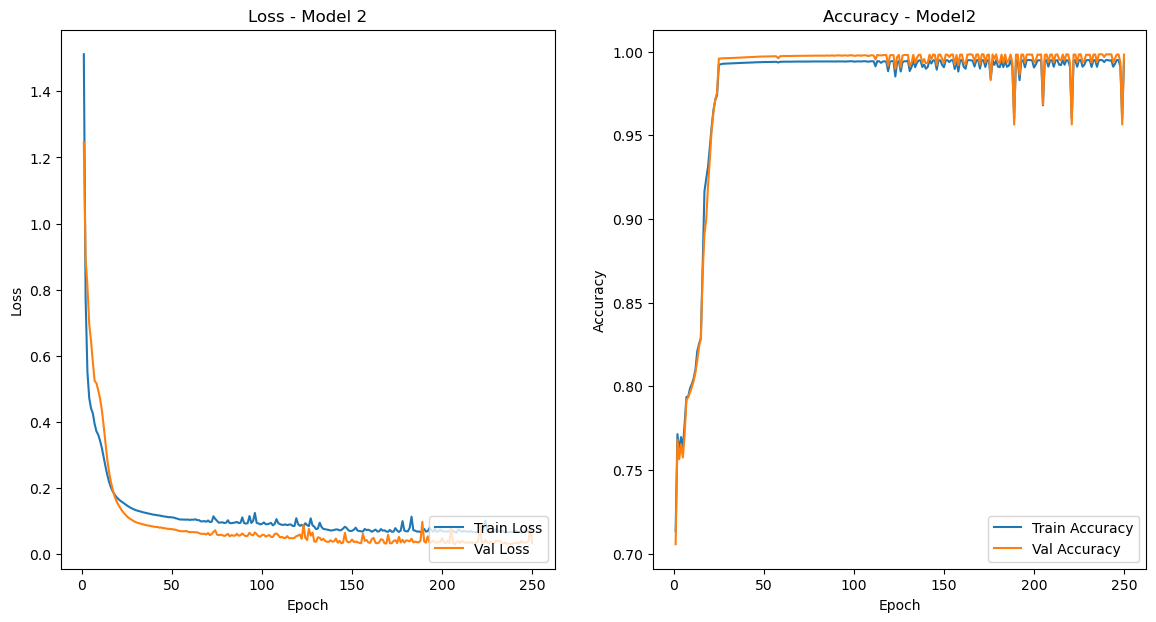

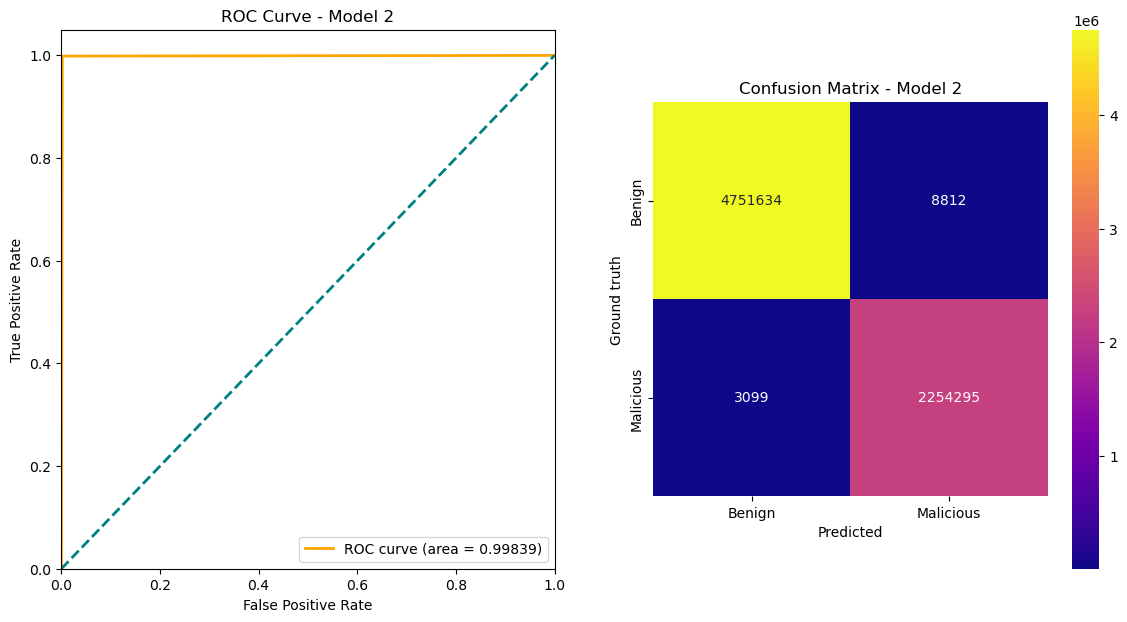

Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

Model 3
Accuracy: 0.9991668376594508
Precision: 0.9989146644389737
Recall: 0.9984947244477481
F1 score: 0.9987046502987812


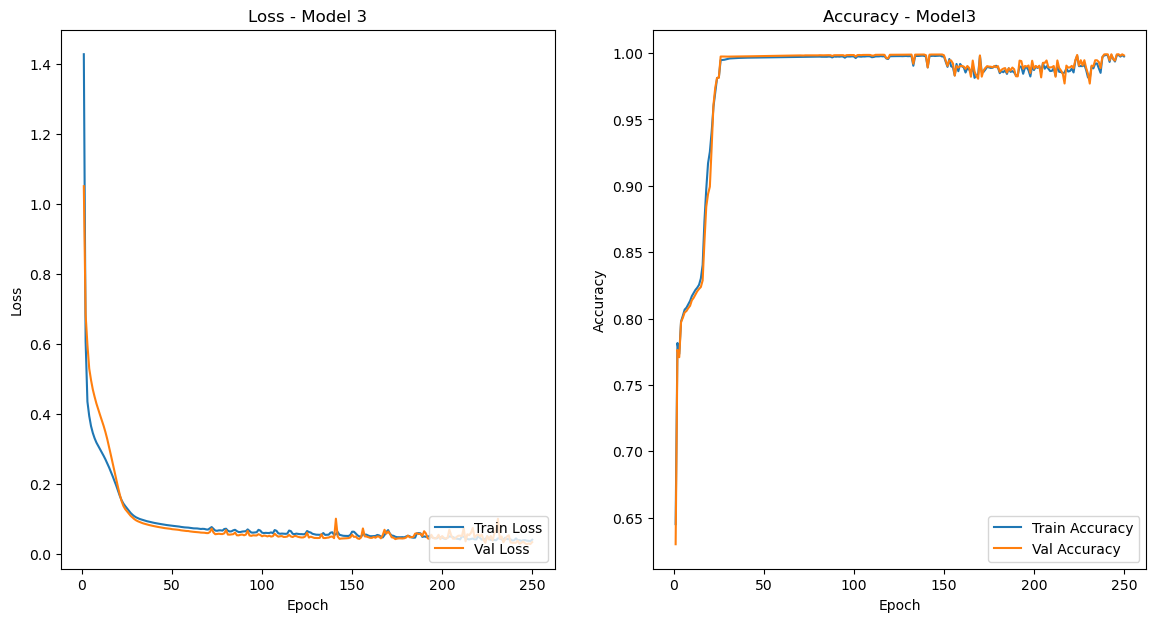

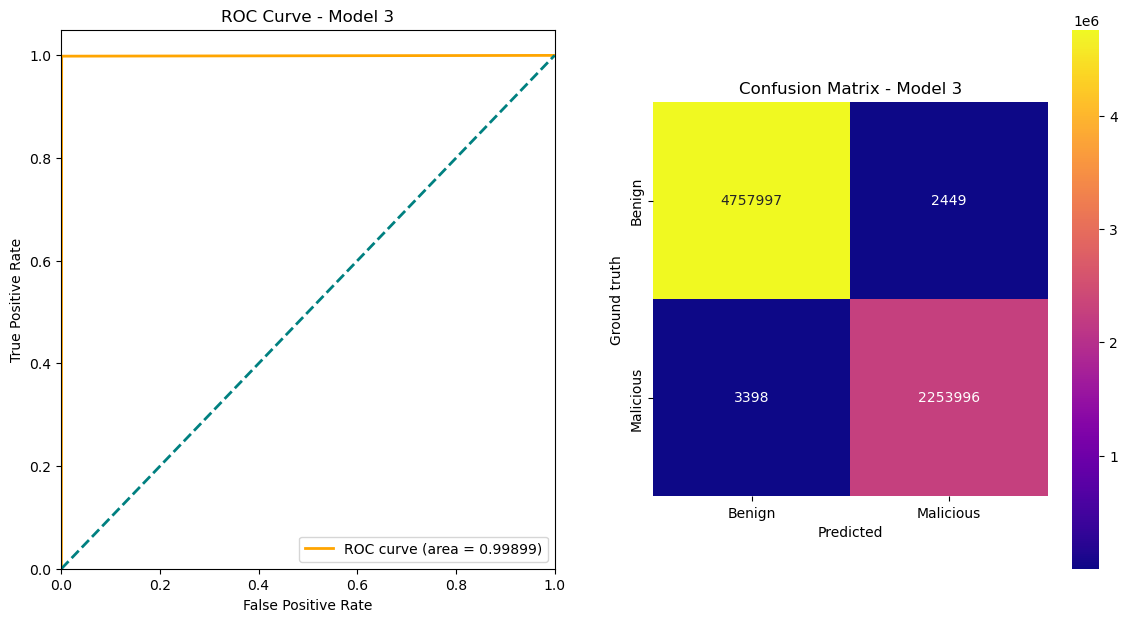

In [10]:
# Model thresholds computed from the previous step
model_thresholds = {'model1': 0.65327, 'model2': 0.4559, 'model3': 0.40924}
# Load models from files
model1.load_state_dict(torch.load(map_location=torch.device(device), f=os.path.join('models', 'model1.pt')))
model2.load_state_dict(torch.load(map_location=torch.device(device), f=os.path.join('models', 'model2.pt')))
model3.load_state_dict(torch.load(map_location=torch.device(device), f=os.path.join('models', 'model3.pt')))

# Set the models to evaluation mode
model1.eval()
model2.eval()
model3.eval()

# Load the models' performance history
with open(os.path.join('models', 'model1_history.json'), "r") as file:
    model1_history = json.load(file)
with open(os.path.join('models', 'model2_history.json'), "r") as file:
    model2_history = json.load(file)
with open(os.path.join('models', 'model3_history.json'), "r") as file:
    model3_history = json.load(file)

models = [model1, model2, model3]
histories = [model1_history, model2_history, model3_history]
thresholds = [model_thresholds['model1'], model_thresholds['model2'], model_thresholds['model3']]


y_true_combined = torch.zeros(1,0,1)
for idx, (model, history, threshold) in enumerate(zip(models, histories, thresholds)):
    y_pred_combined = torch.zeros(1,0,1)
    # Make predictions using the test dataset for all batches
    with torch.no_grad():
        for batch in tqdm(dataloader_cv, total=len(dataloader_cv), desc="Evaluating", unit="batch", colour='orange'):
            y_pred = model(batch[:,:,:15].to(device)).cpu()
            y_pred = (y_pred > threshold).float()
            y_pred_combined = torch.cat((y_pred_combined, y_pred), dim=1)
            # If this is the first iteration of the outermost loop, create a torch tensor composed of ground truth labels
            if idx == 0:
                y_true_combined = torch.cat((y_true_combined, batch[:,:,15].cpu().unsqueeze(2)), dim=1)
    if idx == 0:
        y_true_combined = y_true_combined.numpy().ravel()
    y_pred_combined = y_pred_combined.numpy().ravel()

    print('Model ' + str(idx + 1))
    accuracy = accuracy_score(y_true_combined, y_pred_combined)
    precision = precision_score(y_true_combined, y_pred_combined)
    recall = recall_score(y_true_combined, y_pred_combined)
    f1 = f1_score(y_true_combined, y_pred_combined)
    print('Accuracy: ' + str(accuracy))
    print('Precision: ' + str(precision))
    print('Recall: ' + str(recall))
    print('F1 score: ' + str(f1))

    fig, axs = plt.subplots(1,2, figsize=(14,7))
    axs[0].plot(range(1, history['epochs'] + 1), history['loss'], label='Train Loss')
    axs[0].plot(range(1, history['epochs'] + 1), history['val_loss'], label='Val Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Loss - Model ' + str(idx + 1))
    axs[0].legend(loc='lower right')
    
    axs[1].plot(range(1, history['epochs'] + 1), history['accuracy'], label='Train Accuracy')
    axs[1].plot(range(1, history['epochs'] + 1), history['val_accuracy'], label='Val Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Accuracy - Model' + str(idx + 1))
    axs[1].legend(loc='lower right')

    fpr, tpr, _ = roc_curve(y_true_combined, y_pred_combined)
    roc_auc = auc(fpr, tpr)
    
    fig, axs = plt.subplots(1,2, figsize=(14,7))
    axs[0].plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.5f})')
    axs[0].plot([0, 1], [0, 1], color='teal', lw=2, linestyle='--')
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('ROC Curve - Model ' + str(idx + 1))
    axs[0].legend(loc="lower right")
    
    cm = confusion_matrix(y_true_combined, y_pred_combined)
    sns.heatmap(cm, annot=True, fmt='d', cmap='plasma', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
    axs[1].set_aspect('equal')
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('Ground truth')
    axs[1].set_title('Confusion Matrix - Model ' + str(idx + 1))
    
    plt.show()

# Perform the final evaulation on the test dataset

Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

Model 1
Accuracy: 0.9965885448330833
Precision: 0.9959233502761744
Recall: 0.9936193695604052
F1 score: 0.9947700258612008


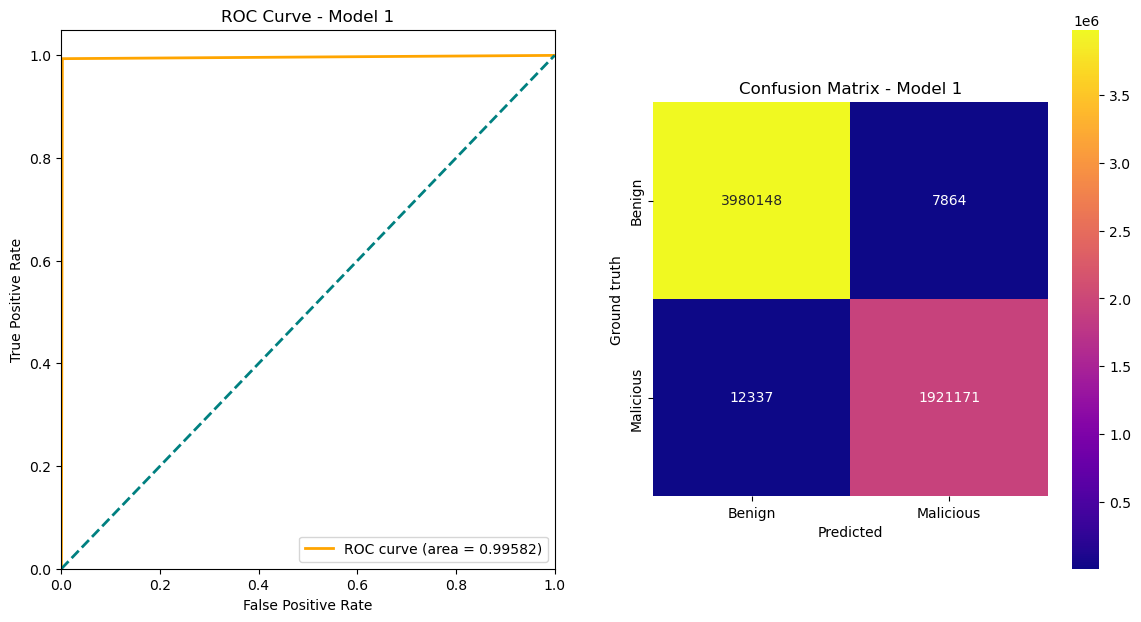

Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

Model 2
Accuracy: 0.9970195152595955
Precision: 0.9939402783285027
Recall: 0.9969501031286139
F1 score: 0.9954429156044702


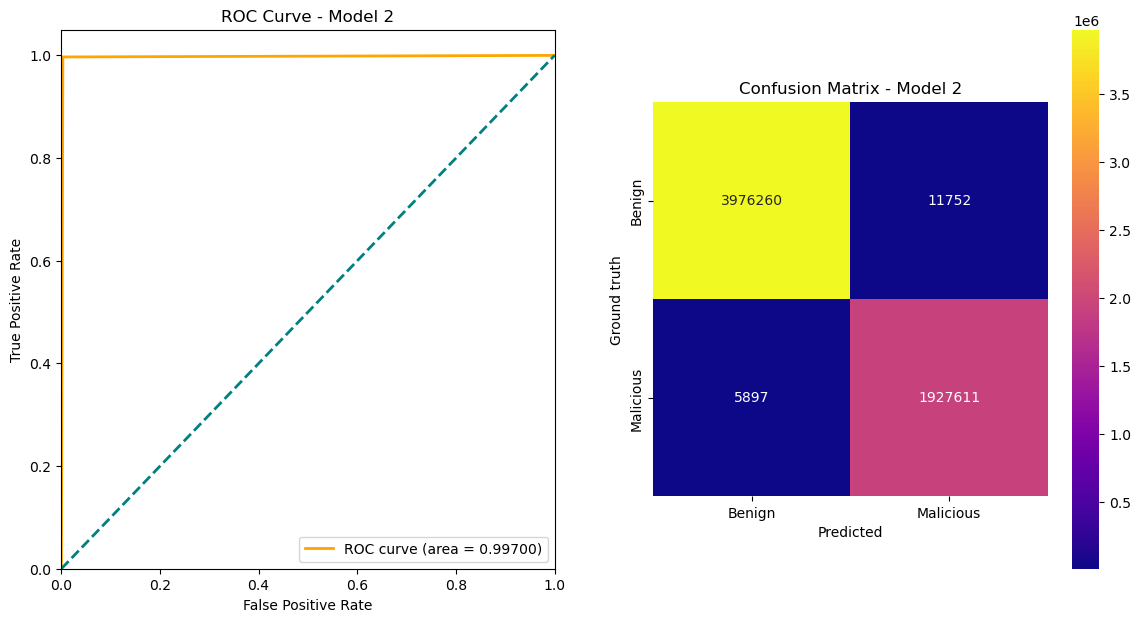

Evaluating:   0%|          | 0/60 [00:00<?, ?batch/s]

Model 3
Accuracy: 0.9977644253502479
Precision: 0.9966424449580292
Recall: 0.9965104876731826
F1 score: 0.9965764619474703


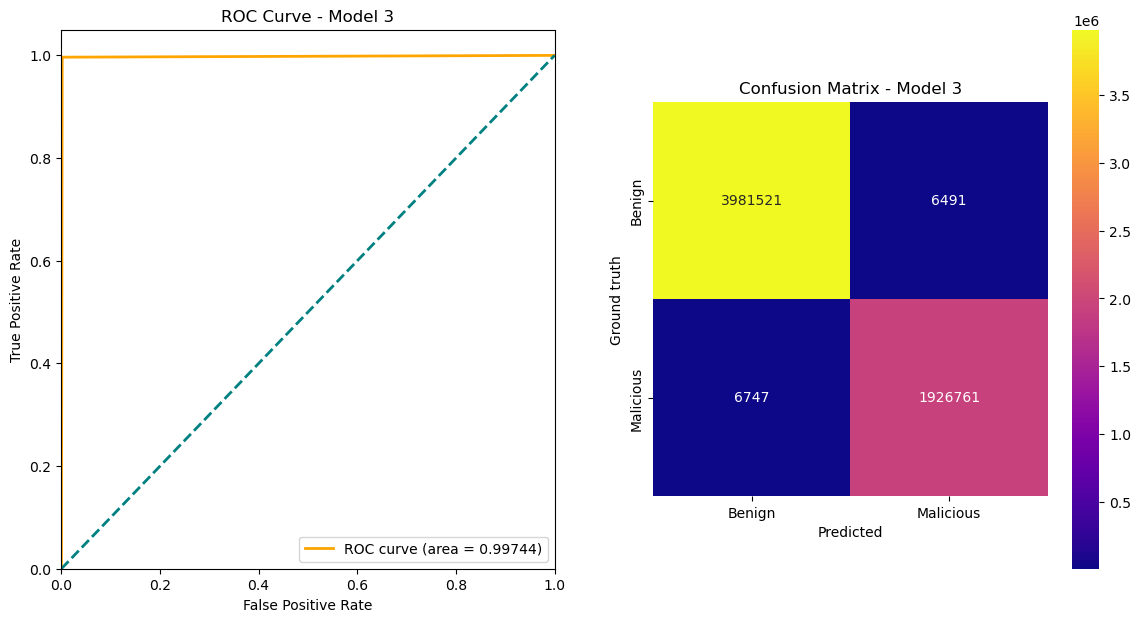

In [11]:
# Load models from files
model1.load_state_dict(torch.load(map_location=torch.device(device), f=os.path.join('models', 'model1.pt')))
model2.load_state_dict(torch.load(map_location=torch.device(device), f=os.path.join('models', 'model2.pt')))
model3.load_state_dict(torch.load(map_location=torch.device(device), f=os.path.join('models', 'model3.pt')))

# Set the models to evaluation mode
model1.eval()
model2.eval()
model3.eval()

models = [model1, model2, model3]
thresholds = [model_thresholds['model1'], model_thresholds['model2'], model_thresholds['model3']]

y_true_combined = torch.zeros(1,0,1)
for idx, (model, threshold) in enumerate(zip(models, thresholds)):
    y_pred_combined = torch.zeros(1,0,1)
    # Make predictions using the test dataset for all batches
    with torch.no_grad():
        for batch in tqdm(dataloader_test, total=len(dataloader_test), desc="Evaluating", unit="batch", colour='orange'):
            y_pred = model(batch[:,:,:15].to(device)).cpu()
            y_pred = (y_pred > threshold).float()
            y_pred_combined = torch.cat((y_pred_combined, y_pred), dim=1)
            # If this is the first iteration of the outermost loop, create a torch tensor composed of ground truth labels
            if idx == 0:
                y_true_combined = torch.cat((y_true_combined, batch[:,:,15].cpu().unsqueeze(2)), dim=1)
    if idx == 0:
        y_true_combined = y_true_combined.numpy().ravel()
    y_pred_combined = y_pred_combined.numpy().ravel()

    print('Model ' + str(idx + 1))
    accuracy = accuracy_score(y_true_combined, y_pred_combined)
    precision = precision_score(y_true_combined, y_pred_combined)
    recall = recall_score(y_true_combined, y_pred_combined)
    f1 = f1_score(y_true_combined, y_pred_combined)
    print('Accuracy: ' + str(accuracy))
    print('Precision: ' + str(precision))
    print('Recall: ' + str(recall))
    print('F1 score: ' + str(f1))

    fpr, tpr, _ = roc_curve(y_true_combined, y_pred_combined)
    roc_auc = auc(fpr, tpr)
    
    fig, axs = plt.subplots(1,2, figsize=(14,7))
    axs[0].plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.5f})')
    axs[0].plot([0, 1], [0, 1], color='teal', lw=2, linestyle='--')
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('ROC Curve - Model ' + str(idx + 1))
    axs[0].legend(loc="lower right")
    
    cm = confusion_matrix(y_true_combined, y_pred_combined)
    sns.heatmap(cm, annot=True, fmt='d', cmap='plasma', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
    axs[1].set_aspect('equal')
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('Ground truth')
    axs[1].set_title('Confusion Matrix - Model ' + str(idx + 1))
    
    plt.show()